
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  0%|          | 0/600 [00:00<?, ?it/s]

Start of training on 15.05.2021 , 19:06:48


  0%|          | 0/600 [00:00<?, ?it/s]

epoch : 1 of 3 , learning rate: 0.01 , runtime: 317.01 seconds
training loss: 0.0015, acc 0.9493 
validation loss: 0.0003, validation acc 0.9902 


  0%|          | 0/600 [00:00<?, ?it/s]

epoch : 2 of 3 , learning rate: 0.01 , runtime: 316.59 seconds
training loss: 0.0003, acc 0.9906 
validation loss: 0.0002, validation acc 0.9916 


100%|██████████| 600/600 [04:58<00:00,  2.01it/s]


epoch : 3 of 3 , learning rate: 0.01 , runtime: 316.4 seconds
training loss: 0.0003, acc 0.9922 
validation loss: 0.0001, validation acc 0.9952 
End of training on 15.05.2021 , 19:22:38


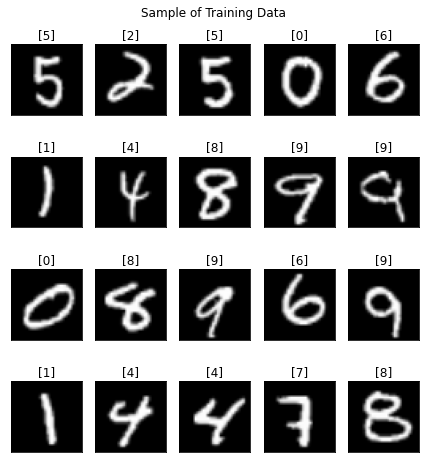

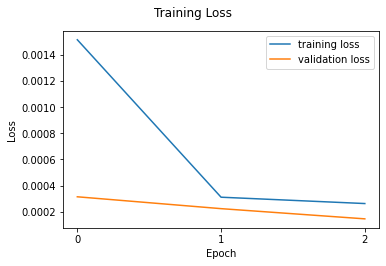

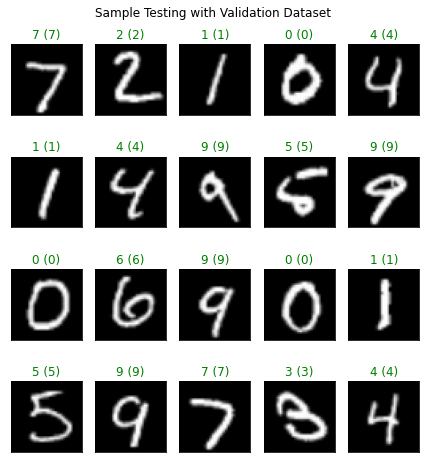

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime
from datetime import date
import time

# Define Model
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            # 192,  64,  96, 128, 16, 32, 32
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self,in_channels):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(in_channels, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        # in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes
        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear1 = nn.Linear(25600, 1024)
        self.linear2 = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.linear1(out))
        out = self.linear2(out)
        return out

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

def detach(tensor):
  tensor.cpu().clone().detach()

if __name__ == '__main__':
  # Load MNIST Dataset
  transform = transforms.Compose([transforms.Resize((45,45)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])
  training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size =100, shuffle=False)


  # Displaying images from training data  
  dataiter = iter(training_loader)
  images, labels = dataiter.next()
  fig = plt.figure(figsize=(6,7))
  for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])
    plt.tight_layout(1.0)
    plt.suptitle("Sample of Training Data")

# Training parameters
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = GoogLeNet(in_channels=1).to(device)

  print_lr = 0.01
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = print_lr,momentum=0.9, weight_decay=5e-4)

  epochs = 3
  running_loss_history = []
  running_corrects_history = []
  val_running_loss_history = []
  val_running_corrects_history = []

# Training Loop
  print("Start of training on", date.today().strftime("%d.%m.%Y"),",",datetime.now().strftime("%H:%M:%S"))
  for e in range(epochs):
    if e>0 and (e<(epochs-1)) and (e%7==0):  
      for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.1
        print_lr = param_group['lr']

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    epoch_start_time = time.time()
    
    for inputs, labels in tqdm(training_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data)

    else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data)

      detach(inputs)
      detach(labels)
      detach(val_inputs)
      detach(val_labels)
      del inputs
      del labels
      del val_inputs
      del val_labels    
      torch.cuda.empty_cache()  

      epoch_run_time = round(time.time() - epoch_start_time,2)
      epoch_loss = running_loss/len(training_loader.dataset)
      epoch_acc = running_corrects.float()/ len(training_loader.dataset)
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_acc)
      
      val_epoch_loss = val_running_loss/len(validation_loader.dataset)
      val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_acc)
      print('epoch :', (e+1),"of",epochs,", learning rate:",print_lr,", runtime:",epoch_run_time,"seconds")
      print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
      print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
  print("End of training on", date.today().strftime("%d.%m.%Y"),",",datetime.now().strftime("%H:%M:%S"))    

# Plot training loss 
  plt.figure()
  plt.plot(running_loss_history, label='training loss')
  plt.plot(val_running_loss_history, label='validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.tight_layout(3.0)
  plt.xticks(ticks=list(range(epochs))) 
  plt.legend()
  plt.suptitle("Training Loss")

# Validation: Show output of trained model
  dataiter = iter(validation_loader)
  images, labels = dataiter.next()
  images = images.to(device)
  labels = labels.to(device)
  output = model(images)
  _, preds = torch.max(output, 1)

  fig = plt.figure(figsize=(6,7))

  for idx in np.arange(20):
    ax = fig.add_subplot(4,5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    plt.suptitle("Sample Testing with Validation Dataset")
    plt.tight_layout(1.0)
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

  model.to('cpu')
  detach(images)
  detach(labels)
  del images
  del labels  

In [ ]:
print(model)

GoogLeNet(
  (pre_layers): Sequential(
    (0): Conv2d(1, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, m